In [1]:
from datafiles_and_parsers.textfile_data import txt_parser
from plot_classes  import *
from matplotlib import transforms
from math import ceil

In [2]:
data = txt_parser('datafiles_and_parsers/tHbb_v31_v3.txt')
numeric_data = data.astype(float)
data0      = numeric_data[numeric_data[1] == 0]
data1      = numeric_data[(numeric_data[1] == 1) & (numeric_data.index != 'gamma_stat_SR_bin_9')]
data_gamma = numeric_data[numeric_data.index == 'gamma_stat_SR_bin_9']

data0_1 = data0.iloc[0:20,:]
data0_2 = data0.iloc[40:60,:]
data0

,1,2,3
0,,,
ATLAS_EG_RESOLUTION,0.0,0.976589,-0.976589
ATLAS_EG_SCALE,0.0,0.976008,-0.976008
ATLAS_EG_SCALE_AF2,0.0,0.976417,-0.976417
ATLAS_EL_ID,0.0,0.975801,-0.975801
ATLAS_EL_Isol,0.0,0.812240,-0.812240
...,...,...,...
ttlight_ISR,0.0,0.908441,-0.908441
ttlight_ISR_hdamp_3mtop,0.0,0.552481,-0.552481
ttlight_ISR_muF,0.0,0.939772,-0.939772


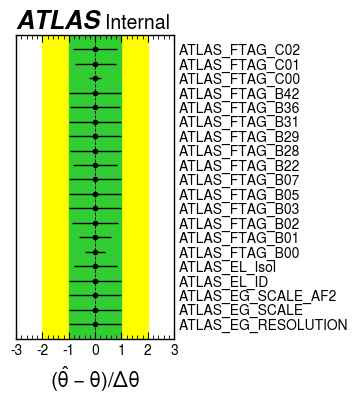

In [6]:
plot = PullPlot(data0.iloc[0:20])
plot.plot_options(rangelist=[-3, 3], center=0)
plot.figure_options(labelside='right')
#plot.color_options(marker='black', onesigma='yellow', twosigma='blue')
plot.create()
# plot.saveimage("PullPlot_demo", 1000)